# Advanced Natural Language Processing Assignment 

# Propaganda Technique Classification Task-2

In [ ]:
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import tensorflow as tf
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 123
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Load Data

In [ ]:
# train_filename = "propaganda_train.tsv"
# test_filename = "propaganda_val.tsv"
train_filename = "/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda_train.tsv"
test_filename = "/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/propaganda_val.tsv"
train_df = pd.read_csv(train_filename, sep = '\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(test_filename, sep = '\t', quoting=csv.QUOTE_NONE)

In [ ]:
train_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [ ]:
test_df.head()

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              2560 non-null   object
 1   tagged_in_context  2560 non-null   object
dtypes: object(2)
memory usage: 40.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   label              640 non-null    object
 1   tagged_in_context  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [ ]:
train_df['label'].unique()

array(['not_propaganda', 'flag_waving', 'loaded_language', 'doubt',
       'name_calling,labeling', 'appeal_to_fear_prejudice', 'repetition',
       'causal_oversimplification', 'exaggeration,minimisation'],
      dtype=object)

In [ ]:
test_df['label'].unique()

array(['not_propaganda', 'causal_oversimplification',
       'appeal_to_fear_prejudice', 'repetition', 'name_calling,labeling',
       'loaded_language', 'flag_waving', 'doubt',
       'exaggeration,minimisation'], dtype=object)

**Only keeping the propaganda technique data**

I removed `not_propaganda` rows from the dataset.

In [ ]:
train_df = train_df[train_df['label'] != 'not_propaganda']
train_df

,label,tagged_in_context
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans..."
8,doubt,"As noted above, at this point literally every ..."
10,"name_calling,labeling",His account was suspended for violating Twitte...
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...
...,...,...
2549,repetition,You might think that would have cured him of f...
2551,"exaggeration,minimisation",“I would like to take this opportunity to make...
2552,flag_waving,Trump To Jeff Sessions: Put An End to Russia P...
2553,causal_oversimplification,<BOS> Neither the Democrat leadership nor the ...


In [ ]:
test_df = test_df[test_df['label'] != 'not_propaganda']
test_df

,label,tagged_in_context
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
4,repetition,It must be exacted from him directly in order ...
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...
6,loaded_language,Health workers have been asked to work with co...
...,...,...
629,flag_waving,"As a result, 58,177 <BOS> Americans <EOS> woul..."
631,flag_waving,<BOS> But if you are a freedom-loving American...
632,loaded_language,I heard lots of <BOS> gut-wrenching stories <E...
638,flag_waving,<BOS> He also sang an Islamic State fight song...


## Propaganda Technique Classification

**preprocessing steps**
* Keep span text between `<BOS>` and `<EOS>` tags to analyze propaganda technique classification task.
* Encoding labels into numerical form

In [ ]:
def get_span(sentence_list):
    span_text = []
    for sentence in sentence_list:
        try:
            text = re.search('<BOS>(.+?)<EOS>',sentence).group(1)
            span_text.append(text)
        except AttributeError:
            # <BOS>, <EOS> not found in the original string
            print("not found") # apply your error handling
    return span_text


In [ ]:
sentences = [sent for sent in train_df["tagged_in_context"]]
span_text = get_span(sentences)
span_text[:5]

[' American people ',
 ' annihilated ',
 ' so-called evidence ',
 ' hateful conduct ',
 ' point to Iran’s positioning itself for more aggressive military actions that could place U.S. forces in harm’s way ']

In [ ]:
train_df['span_text'] = span_text
train_df.head()

,label,tagged_in_context,span_text
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",American people
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated
8,doubt,"As noted above, at this point literally every ...",so-called evidence
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to Iran’s positioning itself for more a...


In [ ]:
train_df['labels'] = train_df['label']
train_df.head()

,label,tagged_in_context,span_text,labels
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",American people,flag_waving
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",annihilated,loaded_language
8,doubt,"As noted above, at this point literally every ...",so-called evidence,doubt
10,"name_calling,labeling",His account was suspended for violating Twitte...,hateful conduct,"name_calling,labeling"
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,point to Iran’s positioning itself for more a...,appeal_to_fear_prejudice


In [ ]:
train_df1 = train_df[['span_text', 'labels']]
train_df1.head()

,span_text,labels
2,American people,flag_waving
5,annihilated,loaded_language
8,so-called evidence,doubt
10,hateful conduct,"name_calling,labeling"
12,point to Iran’s positioning itself for more a...,appeal_to_fear_prejudice


In [ ]:
labels_train = train_df1['labels'].values

In [ ]:
# recoding the nominal labels as numeric
#np.place(labels_train, labels_train=='not_propaganda', '0')
np.place(labels_train, labels_train=='appeal_to_fear_prejudice', '0')
np.place(labels_train, labels_train=='causal_oversimplification', '1')
np.place(labels_train, labels_train=='doubt', '2')
np.place(labels_train, labels_train=='exaggeration,minimisation', '3')
np.place(labels_train, labels_train=='flag_waving', '4')
np.place(labels_train, labels_train=='loaded_language', '5')
np.place(labels_train, labels_train=='name_calling,labeling', '6')
np.place(labels_train, labels_train=='repetition', '7')

print("\n The recoded labels: ", str(np.unique(labels_train)))

# converting from string type to integer type
labels_train = labels_train.astype(int)
print("\n labels: \n"+str(labels_train))


 The recoded labels:  ['0' '1' '2' '3' '4' '5' '6' '7']

 labels: 
[4 5 2 ... 4 1 6]


In [ ]:
train_df1["labels"] = labels_train
train_df1.head()

,span_text,labels
2,American people,4
5,annihilated,5
8,so-called evidence,2
10,hateful conduct,6
12,point to Iran’s positioning itself for more a...,0


In [ ]:
test_sentences = [sent for sent in test_df["tagged_in_context"]]
test_span_text = get_span(test_sentences)

test_span_text[:5]


[' the country would not last long without an outside high IQ elite to run the country ',
 ' gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III ',
 ' infidels ',
 ' the "gay lifestyle ',
 ' devastating communities ']

In [ ]:
test_df['span_text'] = test_span_text
test_df.head()

,label,tagged_in_context,span_text
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...
4,repetition,It must be exacted from him directly in order ...,infidels
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...,"the ""gay lifestyle"
6,loaded_language,Health workers have been asked to work with co...,devastating communities


In [ ]:
test_df['labels'] = test_df['label']
test_df.head()

,label,tagged_in_context,span_text,labels
1,causal_oversimplification,Mostly because <BOS> the country would not las...,the country would not last long without an ou...,causal_oversimplification
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,gets Earl Warren and Sen. Richard Russel to j...,appeal_to_fear_prejudice
4,repetition,It must be exacted from him directly in order ...,infidels,repetition
5,"name_calling,labeling",Is it any wonder that priests and laity alike ...,"the ""gay lifestyle","name_calling,labeling"
6,loaded_language,Health workers have been asked to work with co...,devastating communities,loaded_language


In [ ]:
test_df1 = test_df[['span_text', 'labels']]
test_df1.head()

,span_text,labels
1,the country would not last long without an ou...,causal_oversimplification
2,gets Earl Warren and Sen. Richard Russel to j...,appeal_to_fear_prejudice
4,infidels,repetition
5,"the ""gay lifestyle","name_calling,labeling"
6,devastating communities,loaded_language


In [ ]:
labels_test = test_df1['labels'].values

In [ ]:
# recoding the nominal labels as numeric
#np.place(labels_test, labels_test=='not_propaganda', '0')
np.place(labels_test, labels_test=='appeal_to_fear_prejudice', '0')
np.place(labels_test, labels_test=='causal_oversimplification', '1')
np.place(labels_test, labels_test=='doubt', '2')
np.place(labels_test, labels_test=='exaggeration,minimisation', '3')
np.place(labels_test, labels_test=='flag_waving', '4')
np.place(labels_test, labels_test=='loaded_language', '5')
np.place(labels_test, labels_test=='name_calling,labeling', '6')
np.place(labels_test, labels_test=='repetition', '7')

print("\n The recoded labels: ", str(np.unique(labels_test)))

# converting from string type to integer type
labels_test = labels_test.astype(int)
print("\n labels: \n"+str(labels_test))


 The recoded labels:  ['0' '1' '2' '3' '4' '5' '6' '7']

 labels: 
[1 0 7 6 5 4 2 5 4 0 1 6 3 3 3 6 4 5 2 2 7 3 6 3 2 2 0 4 2 0 4 3 0 0 2 4 3
 4 5 5 5 7 0 4 5 0 7 0 4 0 2 3 6 7 5 4 7 2 2 2 7 6 0 4 3 1 0 6 0 5 2 0 2 6
 0 5 2 3 2 1 4 6 7 3 1 0 1 2 2 7 0 4 1 2 5 6 1 3 6 0 2 0 4 4 6 5 5 5 5 6 0
 2 0 3 5 1 3 1 4 3 2 0 6 0 6 0 0 4 0 4 3 2 7 4 3 3 7 1 5 1 2 2 1 7 6 7 1 1
 6 7 7 5 2 5 4 4 7 4 7 6 5 7 6 1 5 6 4 4 4 2 7 3 7 1 6 4 7 4 1 4 5 0 5 7 6
 6 2 6 4 2 6 1 7 3 2 2 0 6 2 5 3 3 2 1 4 3 4 4 5 0 3 7 7 6 4 3 2 7 6 6 3 6
 6 5 7 0 2 6 1 7 7 7 2 7 3 1 0 5 1 1 2 4 3 2 7 4 5 1 1 1 4 4 0 0 7 5 5 7 0
 0 1 2 7 5 6 0 7 4 1 0 5 7 0 6 1 0 0 5 3 1 0 5 7 5 4 2 4 2 7 0 4 2 1 0 3 1
 7 5 1 4 5 2 2 5 4 4 5 4 1]


In [ ]:
test_df1["labels"] = labels_test
test_df1.head()

,span_text,labels
1,the country would not last long without an ou...,1
2,gets Earl Warren and Sen. Richard Russel to j...,0
4,infidels,7
5,"the ""gay lifestyle",6
6,devastating communities,5


In [ ]:
train_sentences = train_df1['span_text']
train_label = train_df1['labels']

test_sentences = test_df1['span_text']
test_label = test_df1['labels']

## Model

In [ ]:
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, precision_recall_curve, roc_auc_score, accuracy_score

# from keras.preprocessing import text, sequence
# from keras import layers, models, optimizers
# import keras

In [ ]:
labels = ["appeal_to_fear_prejudice", "causal_oversimplification", "doubt", 
          "exaggeration,minimisation", "flag_waving", "loaded_language", "name_calling,labeling", "repetition"]

In [ ]:
# MultinomialNB Classifier
nb = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_sentences, train_label)
predictions_nb = nb.predict(test_sentences)

# calculating accuracy and f1 score
acc_nb = accuracy_score(predictions_nb, test_label)
f1_nb = f1_score(test_label, predictions_nb, average='macro')

print('accuracy: %s' % acc_nb)
print(classification_report(test_label, predictions_nb, target_names=labels))
print('f1 score: %s' % f1_nb)

accuracy: 0.44336569579288027
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.56      0.47      0.51        43
causal_oversimplification       0.29      0.86      0.44        35
                    doubt       0.40      0.44      0.42        43
exaggeration,minimisation       0.33      0.43      0.37        30
              flag_waving       0.66      0.60      0.63        45
          loaded_language       0.73      0.21      0.32        39
    name_calling,labeling       0.50      0.26      0.35        34
               repetition       0.79      0.28      0.41        40

                 accuracy                           0.44       309
                macro avg       0.53      0.44      0.43       309
             weighted avg       0.54      0.44      0.44       309

f1 score: 0.4299255427824808


In [ ]:
accuracy, f1 = [], []
accuracy.append(acc_nb)
f1.append(f1_nb)

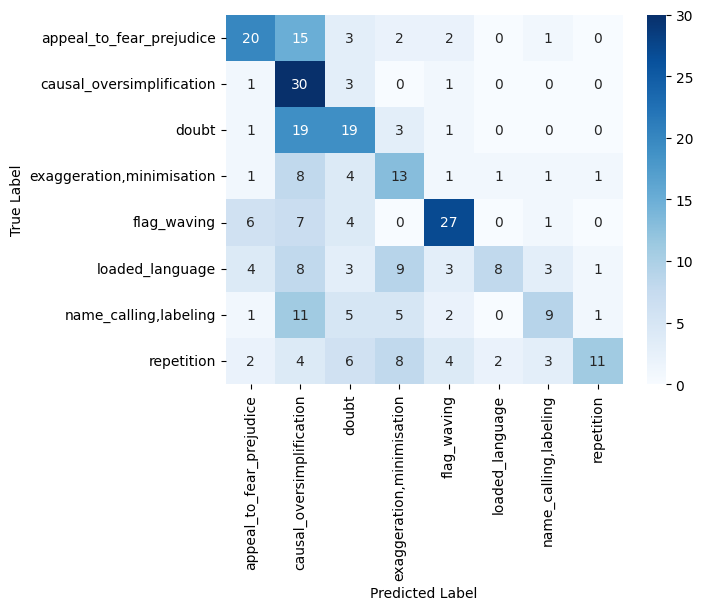

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(test_label, predictions_nb).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Auc: 0.86


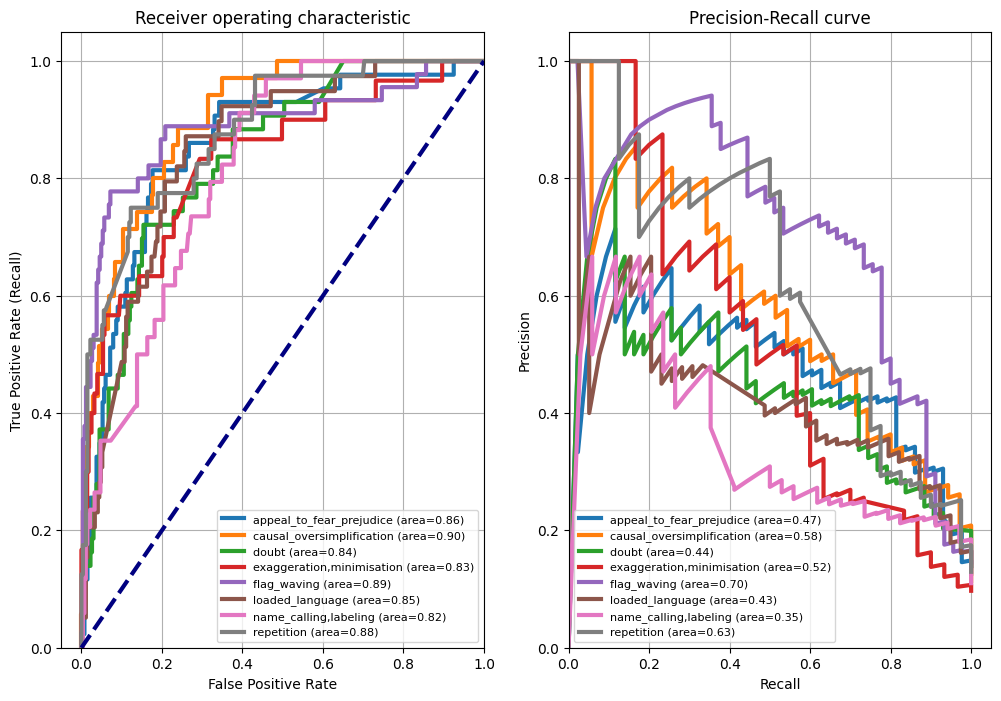

In [ ]:
#classes = np.unique(test_label)
y_test_array = pd.get_dummies(test_label, drop_first=False).values
predicted_prob_nb = nb.predict_proba(test_sentences)

auc_nb = roc_auc_score(test_label, predicted_prob_nb, 
                            multi_class="ovr")
print("Auc:", round(auc_nb,2))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,8))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob_nb[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(labels[i], auc(fpr, tpr)))
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right", fontsize = 8)
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob_nb[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(labels[i], auc(recall, precision)))
    
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best", fontsize = 8)
ax[1].grid(True)
plt.show()

In [ ]:
# # Implementing Logistic Regression

logreg = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))), 
                ('clf', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=random_seed)),
               ])
logreg.fit(train_sentences, train_label)

predictions_logreg = logreg.predict(test_sentences)

# calculating accuracy and f1 score
acc_lr = accuracy_score(predictions_logreg, test_label)
f1_lr = f1_score(test_label, predictions_logreg, average='macro')

accuracy.append(acc_lr)
f1.append(f1_lr)

print('accuracy: %s' % acc_lr)
print(classification_report(test_label, predictions_logreg, target_names=labels))
print('f1 score: %s' % f1_lr)

accuracy: 0.4886731391585761
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.54      0.47      0.50        43
causal_oversimplification       0.33      0.57      0.42        35
                    doubt       0.53      0.49      0.51        43
exaggeration,minimisation       0.45      0.47      0.46        30
              flag_waving       0.76      0.58      0.66        45
          loaded_language       0.43      0.59      0.49        39
    name_calling,labeling       0.41      0.35      0.38        34
               repetition       0.65      0.38      0.48        40

                 accuracy                           0.49       309
                macro avg       0.51      0.49      0.49       309
             weighted avg       0.52      0.49      0.49       309

f1 score: 0.48646268970661666


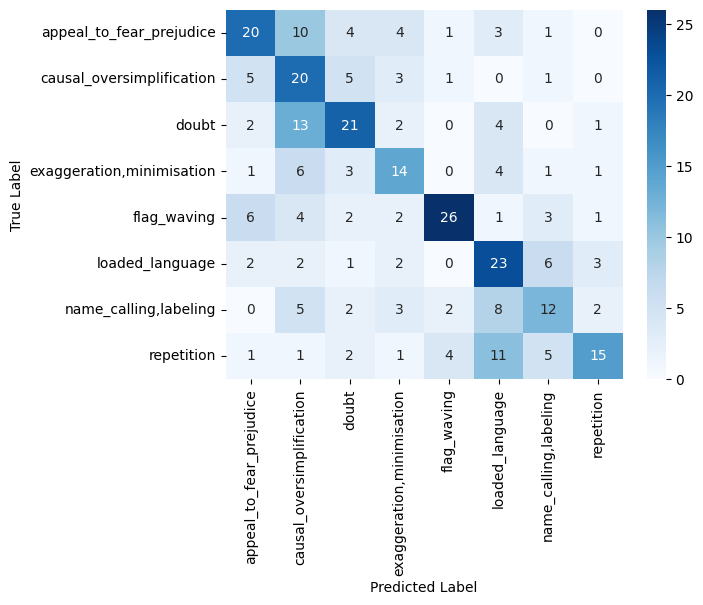

In [ ]:
# Plotting a confusion matrix
cm_logreg = confusion_matrix(test_label, predictions_logreg).astype(int)
sns.heatmap(cm_logreg, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Auc: 0.86


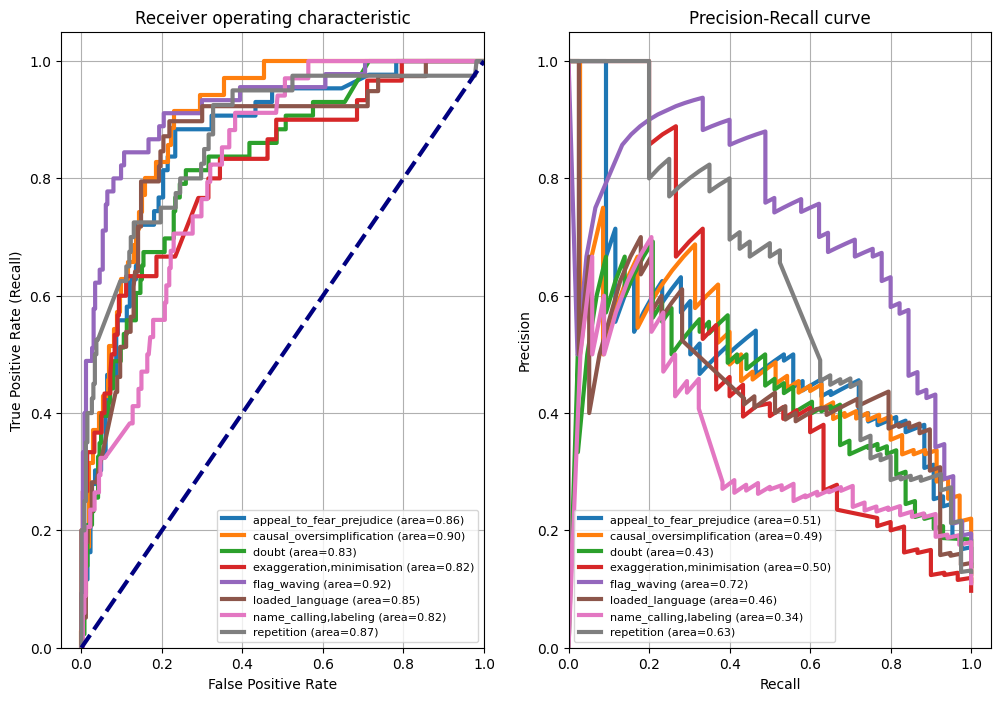

In [ ]:
#y_test_array = pd.get_dummies(test_label, drop_first=False).values
predicted_prob_lr = logreg.predict_proba(test_sentences)

auc_lr = roc_auc_score(test_label, predicted_prob_lr, 
                            multi_class="ovr")
print("Auc:", round(auc_lr,2))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,8))
## Plot roc
for i in range(len(labels)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                           predicted_prob_lr[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(labels[i], auc(fpr, tpr)))
    
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right", fontsize = 8)
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(labels)):
    precision, recall, thresholds = precision_recall_curve(
                 y_test_array[:,i], predicted_prob_lr[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(labels[i], auc(recall, precision)))
    
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best", fontsize = 8)
ax[1].grid(True)
plt.show()

In [ ]:
# Implementing SGD Classifier

sgd = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, tol=None, random_state=random_seed)),
               ])
sgd.fit(train_sentences, train_label)

predictions_sgd = sgd.predict(test_sentences)

# calculating accuracy and f1 score
acc_sgd = accuracy_score(predictions_sgd, test_label)
f1_sgd = f1_score(test_label, predictions_sgd, average='macro')

accuracy.append(acc_sgd)
f1.append(f1_sgd)

print('accuracy: %s' % acc_sgd)
print(classification_report(test_label, predictions_sgd, target_names=labels))
print('f1 score: %s' % f1_sgd)

accuracy: 0.4886731391585761
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.45      0.42      0.43        43
causal_oversimplification       0.36      0.49      0.41        35
                    doubt       0.49      0.56      0.52        43
exaggeration,minimisation       0.44      0.37      0.40        30
              flag_waving       0.64      0.71      0.67        45
          loaded_language       0.43      0.46      0.44        39
    name_calling,labeling       0.47      0.41      0.44        34
               repetition       0.65      0.42      0.52        40

                 accuracy                           0.49       309
                macro avg       0.49      0.48      0.48       309
             weighted avg       0.50      0.49      0.49       309

f1 score: 0.4801110483321947


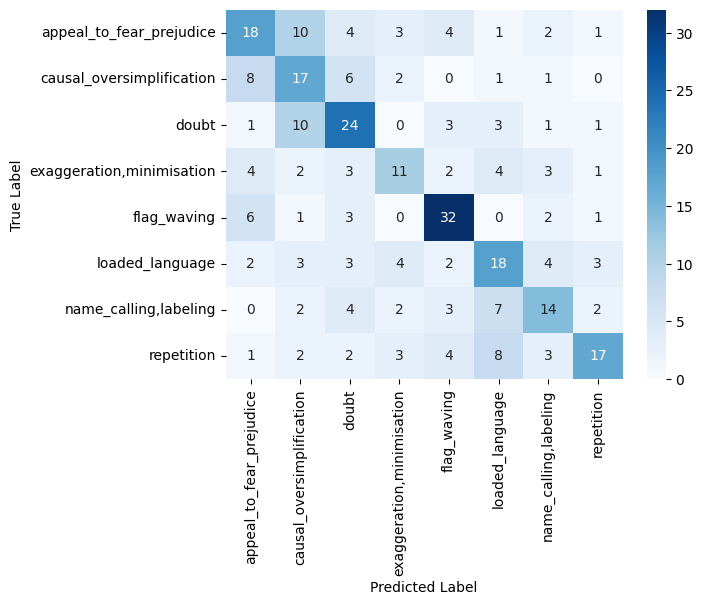

In [ ]:
# Plotting a confusion matrix
cm_sgd = confusion_matrix(test_label, predictions_sgd).astype(int)
sns.heatmap(cm_sgd, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Implementing XGB Classifier

xgbc = Pipeline([('tfidfVec', TfidfVectorizer(ngram_range = (1, 1))), 
                ('clf', XGBClassifier(random_state=random_seed)),
               ])
xgbc.fit(train_sentences, train_label)

predictions_xgbc = xgbc.predict(test_sentences)

# calculating accuracy and f1 score
acc_xgb = accuracy_score(predictions_xgbc, test_label)
f1_xgb = f1_score(test_label, predictions_xgbc, average='macro')

accuracy.append(acc_xgb)
f1.append(f1_xgb)

print('accuracy: %s' % acc_xgb)
print(classification_report(test_label, predictions_xgbc, target_names=labels))
print('f1 score: %s' % f1_xgb)

accuracy: 0.44983818770226536
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.34      0.28      0.31        43
causal_oversimplification       0.36      0.49      0.41        35
                    doubt       0.49      0.44      0.46        43
exaggeration,minimisation       0.38      0.33      0.36        30
              flag_waving       0.74      0.58      0.65        45
          loaded_language       0.38      0.74      0.50        39
    name_calling,labeling       0.58      0.41      0.48        34
               repetition       0.46      0.30      0.36        40

                 accuracy                           0.45       309
                macro avg       0.47      0.45      0.44       309
             weighted avg       0.47      0.45      0.45       309

f1 score: 0.4424098662061236


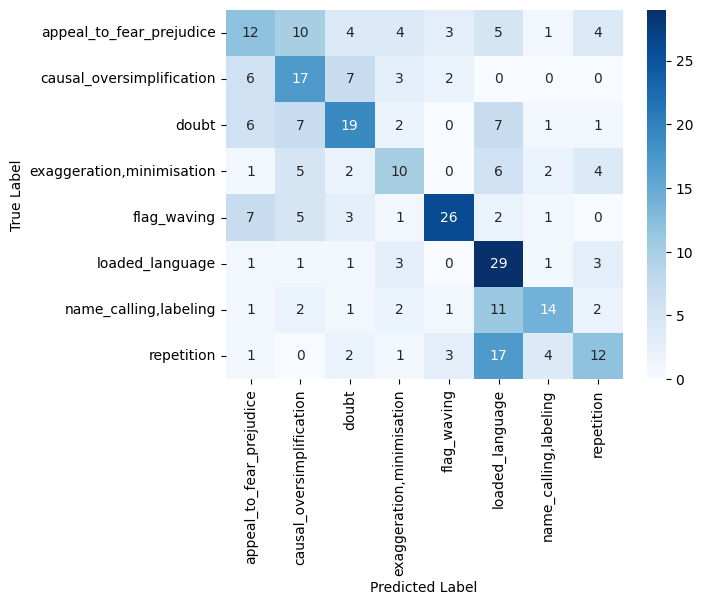

In [ ]:
# Plotting a confusion matrix
cm_xgbc = confusion_matrix(test_label, predictions_xgbc).astype(int)
sns.heatmap(cm_xgbc, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
models = ['MultinomialNB', 'Logistic Regression', 'SGD Classifier', 'XGBoost Classifier']
matrics_dict = {'Accuracy': accuracy, 'F1-Score': f1}  # 'Models': model, 

model_df = pd.DataFrame(matrics_dict.values(), columns = models).T
model_df.columns = ['Accuracy', 'F1-score']
model_df = model_df.sort_values(by = ['F1-score'], ascending = False)   # sort value according to highest f1-score 
model_df

,Accuracy,F1-score
Logistic Regression,0.488673,0.486463
SGD Classifier,0.488673,0.480111
XGBoost Classifier,0.449838,0.442410
MultinomialNB,0.443366,0.429926


## Gensim Word2Vec

Word2Vec is widely used in many applications like document similarity and retrieval, machine translations, etc.

In [ ]:
from gensim.models import Word2Vec
from tqdm import tqdm
from collections import defaultdict

In [ ]:
tokenized_sents=[]
for sent in tqdm(train_sentences):
    tokenized_sents.append(sent.split())

100%|██████████| 1291/1291 [00:00<00:00, 461663.10it/s]


In [ ]:
test_tokenized_sents=[]
for sent in tqdm(test_sentences):
    test_tokenized_sents.append(sent.split())

100%|██████████| 309/309 [00:00<00:00, 435058.72it/s]


####Training a Word2Vec Model

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
print(gensim.__version__)

4.3.1


In [ ]:
model_wv = Word2Vec(sentences=tokenized_sents, min_count=1, vector_size=100,  window=5, workers = 2, seed = random_seed)

In [ ]:
# Total number of words in the Vocabulary on which the Word2Vec model is trained.
vocab_wv=list(model_wv.wv.index_to_key)
print(len(vocab_wv))

4407


In [ ]:
vocab_wv[0:10]

['the', 'of', 'to', 'and', 'a', 'in', 'that', 'is', 'it', 'for']

In [ ]:
model_wv.wv.get_vector('he')

array([-1.79981496e-02,  4.48433980e-02, -1.05918422e-02,  8.67840368e-03,
        1.50156394e-03, -6.78956658e-02,  3.41799222e-02,  1.25266999e-01,
       -5.53117953e-02, -4.24868502e-02, -7.43780937e-03, -9.72068459e-02,
        1.52609646e-02,  4.80508618e-02,  9.80381947e-03, -5.26495352e-02,
        4.86298203e-02, -5.75172156e-02, -1.29809324e-02, -1.32844836e-01,
        4.33914028e-02,  3.51730778e-05,  6.11162670e-02, -2.16996558e-02,
        6.83234353e-03, -1.37330862e-02, -5.32308109e-02, -5.00384765e-03,
       -5.46147749e-02, -3.72079643e-03,  7.39139169e-02,  2.45962001e-04,
        3.95708159e-02, -7.27072507e-02, -2.77806632e-02,  5.67688905e-02,
        8.73448886e-03, -3.61919738e-02, -3.60302702e-02, -9.70434546e-02,
       -8.01208895e-03, -2.08553467e-02, -3.23824398e-02,  2.17920728e-03,
        6.15377836e-02, -2.08987314e-02, -7.45386481e-02, -1.43235726e-02,
        4.20160703e-02,  5.06135002e-02,  5.63815609e-03, -3.79626304e-02,
       -3.40578668e-02, -

In [ ]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats_w2vec(list_of_lists, model):
    dimension = 100
    zero_vector = np.zeros(dimension)
    feats = []
    for tokens in list_of_lists:
        vector =  np.zeros(dimension)
        count = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in model.wv:
                vector += model.wv[token]
                count +=1
        if(count!=0):
            feats.append(vector/count) 
        else:
            feats.append(zero_vector)
    return feats

In [ ]:
train_transformed = embedding_feats_w2vec(tokenized_sents, model_wv)
test_transformed = embedding_feats_w2vec(test_tokenized_sents, model_wv)

In [ ]:
train_transformed[0]

array([-0.0194393 , -0.02373827,  0.02221057, -0.07719067, -0.0447762 ,
       -0.05786773, -0.0131919 , -0.04159022,  0.00011542, -0.03912299,
       -0.05676573,  0.06745325, -0.03129421,  0.02281334, -0.02658625,
       -0.03662529, -0.01362959,  0.0359615 ,  0.01260146,  0.03592798,
       -0.01365708, -0.00986859,  0.03744931,  0.03846958, -0.01662631,
       -0.05931691,  0.02036566, -0.02530466,  0.00757628, -0.01136758,
       -0.0111166 , -0.06864656, -0.01659369,  0.00445787,  0.02574116,
        0.03855743, -0.0028101 ,  0.04810416,  0.04835211, -0.02659624,
        0.01591382, -0.02935761, -0.03389964,  0.00029824, -0.00737823,
       -0.02895884, -0.05973386,  0.01610164,  0.00555033, -0.01684997,
        0.0624997 , -0.00236201, -0.0574155 ,  0.00013882, -0.00164679,
       -0.01645135, -0.04526941,  0.00012669, -0.00612487, -0.01824263,
       -0.00039878,  0.00694887, -0.02610557, -0.02143427, -0.02488023,
       -0.0256477 ,  0.04058907, -0.00142328, -0.02064791,  0.01

In [ ]:
test_transformed[0]

array([-0.02711678, -0.02288252,  0.02437485, -0.08512102, -0.04314619,
       -0.06260053, -0.01540521, -0.04883492,  0.00216259, -0.04162069,
       -0.06582637,  0.08050069, -0.03718764,  0.02494409, -0.022485  ,
       -0.04782156, -0.01035308,  0.03325985,  0.01897877,  0.04102372,
       -0.01501102, -0.01027901,  0.04086214,  0.04865683, -0.0090641 ,
       -0.06943726,  0.02560787, -0.02608583,  0.01973217, -0.01192485,
       -0.01690424, -0.08287127, -0.02802116,  0.01277968,  0.03931564,
        0.03622361, -0.00446066,  0.0527369 ,  0.04822623, -0.03220949,
        0.02132827, -0.03361293, -0.04691272,  0.00635469, -0.01010994,
       -0.03170859, -0.06237123,  0.01985584, -0.00064625, -0.0257598 ,
        0.0630791 , -0.01000141, -0.07430085,  0.00402539, -0.01635504,
       -0.01891093, -0.0617048 ,  0.00173821,  0.0007435 , -0.01636728,
        0.00479847,  0.01234517, -0.0259078 , -0.02351061, -0.0297124 ,
       -0.03712767,  0.0388274 , -0.00288466, -0.02881112,  0.01

In [ ]:
# Classifiers
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Linear SVM",
    "Random Forest",
    "SGD Classifier",
    "XGBoost",
]
random_seed = 123
model_list = [
    LogisticRegression(solver='lbfgs', multi_class='auto', random_state = random_seed),
    KNeighborsClassifier(n_neighbors = 7, n_jobs = -1),
    DecisionTreeClassifier(random_state=random_seed),
    SVC(kernel = 'linear', random_state=random_seed),
    RandomForestClassifier(n_estimators = 100, random_state = random_seed),
    SGDClassifier(loss = 'hinge', random_state=random_seed),
    XGBClassifier(random_state=random_seed),
]

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_test, y_test, names = names, models = model_list):
    score_df, score_train, score_test, f1_ = pd.DataFrame(), [], [], []
    for model in model_list:
        model.fit(X_train, y_train)
        y_train_pred, y_test_pred = model.predict(X_train), model.predict(X_test)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_test.append(accuracy_score(y_test, y_test_pred))
        f1_.append(f1_score(y_test, y_test_pred, average='macro'))
    
    score_df["Classifier"], score_df["Training accuracy"], score_df["Test accuracy"], score_df["F1-Score"] = names, score_train, score_test, f1_
    score_df.sort_values(by = 'Test accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Summary of baseline models
score(train_transformed, train_label, test_transformed, test_label, names = names, models = model_list)

,Classifier,Training accuracy,Test accuracy,F1-Score
4,Random Forest,0.991479,0.294498,0.289080
6,XGBoost,0.991479,0.275081,0.269332
2,Decision Tree,0.991479,0.258900,0.256849
3,Linear SVM,0.216112,0.200647,0.090446
1,KNN Classifier,0.387297,0.197411,0.182573
5,SGD Classifier,0.221534,0.190939,0.117755
0,Logistic Regression,0.202943,0.187702,0.095807


### Model Evaluation

Using RandomForestClassifier and XGBoost Classifier to predict propaganda technique in a given sentence.

In [ ]:
np.any(np.isnan(train_transformed))

False

In [ ]:
# random forest classifier
clf_rfc = RandomForestClassifier(n_estimators = 100, random_state=random_seed)
clf_rfc.fit(train_transformed,train_label)
predictions_rfc = clf_rfc.predict(test_transformed)

print('accuracy: %s' % accuracy_score(predictions_rfc, test_label))
print(classification_report(test_label, predictions_rfc, target_names=labels))
print('f1 score: %s' % f1_score(test_label, predictions_rfc, average='macro'))

accuracy: 0.29449838187702265
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.20      0.14      0.16        43
causal_oversimplification       0.25      0.46      0.33        35
                    doubt       0.32      0.16      0.22        43
exaggeration,minimisation       0.22      0.27      0.24        30
              flag_waving       0.42      0.36      0.39        45
          loaded_language       0.38      0.21      0.27        39
    name_calling,labeling       0.22      0.41      0.29        34
               repetition       0.46      0.40      0.43        40

                 accuracy                           0.29       309
                macro avg       0.31      0.30      0.29       309
             weighted avg       0.31      0.29      0.29       309

f1 score: 0.28908000690563346


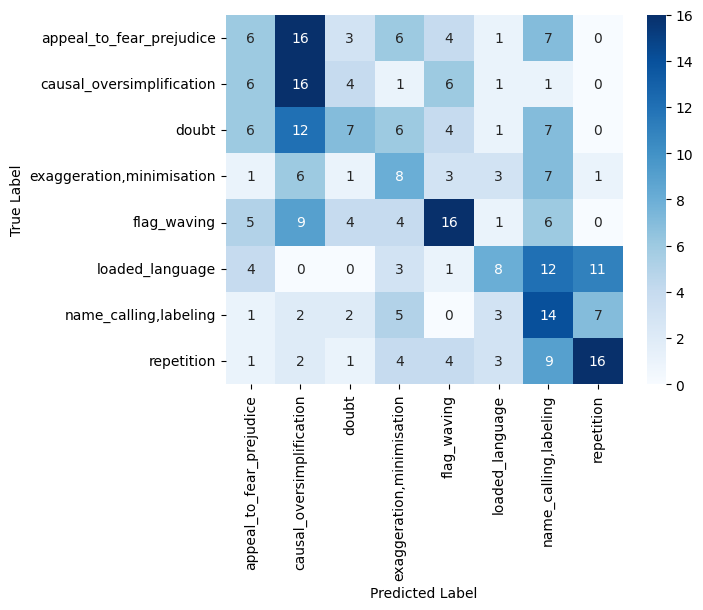

In [ ]:
# Plotting a confusion matrix
cm_rfc = confusion_matrix(test_label, predictions_rfc).astype(int)
sns.heatmap(cm_rfc, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# random forest classifier
clf_xgb = XGBClassifier(n_estimators = 100, random_state=random_seed)
clf_xgb.fit(train_transformed,train_label)
predictions_xgb = clf_xgb.predict(test_transformed)

print('accuracy: %s' % accuracy_score(predictions_xgb, test_label))
print(classification_report(test_label, predictions_xgb, target_names=labels))
print('f1 score: %s' % f1_score(test_label, predictions_xgb, average='macro'))

accuracy: 0.2750809061488673
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.29      0.23      0.26        43
causal_oversimplification       0.23      0.26      0.24        35
                    doubt       0.25      0.14      0.18        43
exaggeration,minimisation       0.13      0.17      0.14        30
              flag_waving       0.34      0.36      0.35        45
          loaded_language       0.26      0.21      0.23        39
    name_calling,labeling       0.25      0.50      0.33        34
               repetition       0.52      0.35      0.42        40

                 accuracy                           0.28       309
                macro avg       0.28      0.28      0.27       309
             weighted avg       0.29      0.28      0.27       309

f1 score: 0.2693321016812256


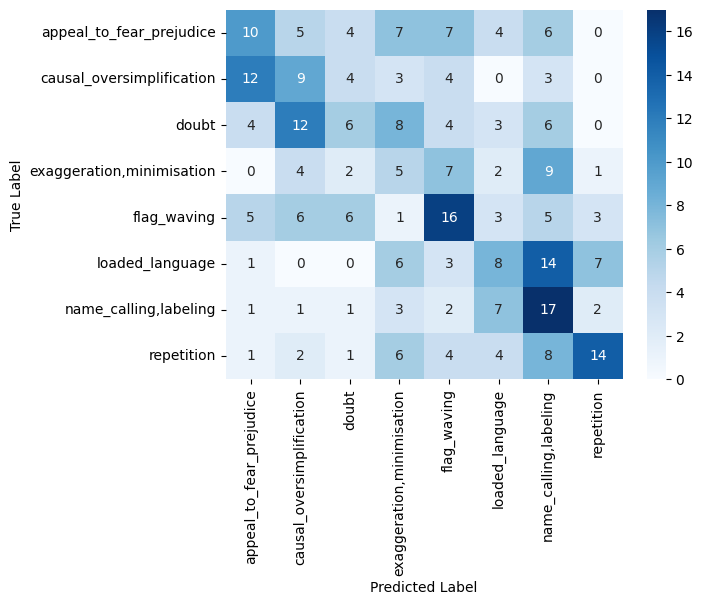

In [ ]:
# Plotting a confusion matrix
cm_xgbc = confusion_matrix(test_label, predictions_xgb).astype(int)
sns.heatmap(cm_xgbc, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Google news negative word2vec

A pre-trained Word2vec model for doing feature extraction and performing text classification.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gensim.models import KeyedVectors


In [ ]:
# download GoogleNews-vectors-negative300.bin.gz
# https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300
# Or 
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [ ]:
# Loading the pre-trained Word2Vec model
# word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary = True)

In [ ]:
# I implemented this from the Stack Overflow website answer with some modification
def plot_embedding(X, y):
    truncated_SVD = TruncatedSVD(n_components = 2, random_state = random_seed) # Dimensionality reduction using truncated SVD
    truncated_SVD.fit(X)
    scores = truncated_SVD.transform(X)
    color_mapper = {label:idx for idx, label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ['red', 'blue', 'green', 'black', 'orange', 'gray', 'purple', 'lightgreen']
        
    plt.scatter(scores[:, 0], scores[:, 1], s = 8, alpha = 0.8, c = y, cmap = matplotlib.colors.ListedColormap(colors))
    red_patch = mpatches.Patch(color = 'red', label = 'appeal_to_fear_prejudice')
    blue_patch = mpatches.Patch(color = 'blue', label = 'causal_oversimplification')
    green_patch = mpatches.Patch(color = 'green', label = 'doubt')
    black_patch = mpatches.Patch(color = 'black', label = 'exaggeration,minimisation')
    orange_patch = mpatches.Patch(color = 'orange', label = 'flag_waving')
    gray_patch = mpatches.Patch(color = 'gray', label = 'loaded_language')
    purple_patch = mpatches.Patch(color = 'purple', label = 'name_calling,labeling')
    lightgreen_patch = mpatches.Patch(color = 'lightgreen', label = 'repetition')
    plt.legend(handles = [red_patch, blue_patch, green_patch, black_patch, orange_patch, gray_patch, purple_patch, lightgreen_patch], prop = {"size": 12})

In [ ]:
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists, model):
    dimension = 300
    zero_vector = np.zeros(dimension)
    feats = []
    for tokens in list_of_lists:
        vector =  np.zeros(dimension)
        count = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in model:
                vector += model[token]
                count +=1
        if(count!=0):
            feats.append(vector/count) 
        else:
            feats.append(zero_vector)
    return feats

In [ ]:
train_vectors = embedding_feats(tokenized_sents, word2vec)
test_vectors = embedding_feats(test_tokenized_sents, word2vec)

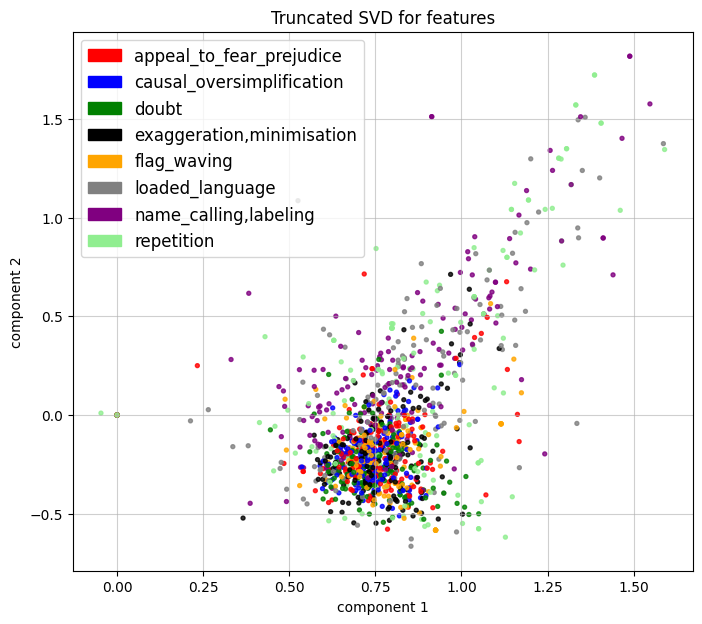

In [ ]:
fig = plt.figure(figsize = (8, 7))          
plot_embedding(train_vectors, train_label)
plt.grid(alpha = 0.6)
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("Truncated SVD for features")

# save plot
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/svd_feat2.jpg', bbox_inches='tight', dpi = 300)

plt.show()

From the above graph it is clearly visible that it is very hard to differentiate all the techniques, they are closely clustered together. Only few values from `loaded_language`, `name_calling,labelling` and `repetition` are differentiatable.

In [ ]:
# Summary of baseline models
score(train_vectors, train_label, test_vectors, test_label, names = names, models = model_list)

,Classifier,Training accuracy,Test accuracy,F1-Score
0,Logistic Regression,0.723470,0.491909,0.494158
4,Random Forest,0.983734,0.485437,0.484588
6,XGBoost,0.983734,0.485437,0.483765
3,Linear SVM,0.755229,0.462783,0.453875
5,SGD Classifier,0.780015,0.420712,0.422398
2,Decision Tree,0.983734,0.307443,0.308222
1,KNN Classifier,0.411309,0.288026,0.263182


In [ ]:
# Logistic Regression 
lr = LogisticRegression(solver='lbfgs', multi_class='auto', random_state = random_seed)
lr.fit(train_vectors, train_label)

predictions_lr = lr.predict(test_vectors)

print('accuracy: %s' % accuracy_score(predictions_lr, test_label))
print(classification_report(test_label, predictions_lr, target_names=labels))
print('f1 score: %s' % f1_score(test_label, predictions_lr, average='macro'))

accuracy: 0.4919093851132686
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.49      0.46        43
causal_oversimplification       0.28      0.46      0.35        35
                    doubt       0.57      0.65      0.61        43
exaggeration,minimisation       0.57      0.53      0.55        30
              flag_waving       0.70      0.51      0.59        45
          loaded_language       0.50      0.46      0.48        39
    name_calling,labeling       0.55      0.47      0.51        34
               repetition       0.48      0.35      0.41        40

                 accuracy                           0.49       309
                macro avg       0.51      0.49      0.49       309
             weighted avg       0.52      0.49      0.50       309

f1 score: 0.49415769221616296


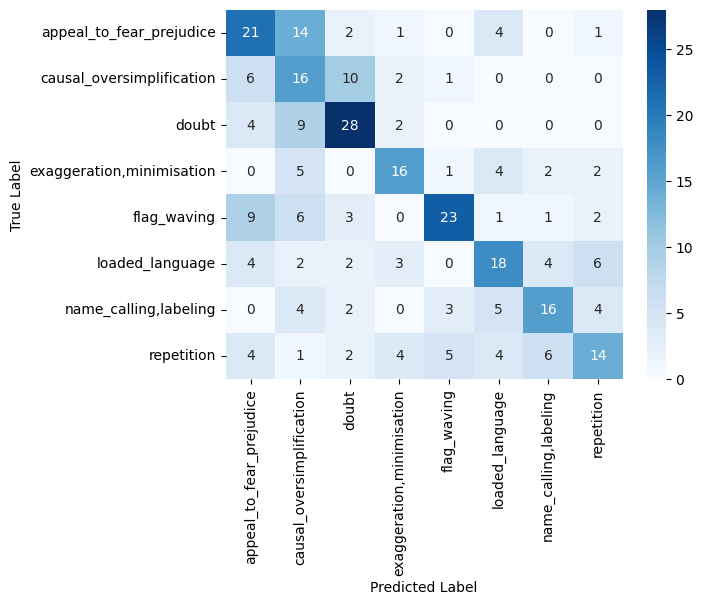

In [ ]:
# Plotting a confusion matrix
cm_lr = confusion_matrix(test_label, predictions_lr)
sns.heatmap(cm_lr, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Neural Network

### Propaganda technique classification using CNN

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding, Bidirectional, LSTM
from keras.layers import Permute, multiply
from keras.layers import MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import concatenate
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from numpy import array

In [ ]:
X_train = train_df1['span_text'].values
Y_train = train_df1['labels'].values

X_test = test_df1['span_text'].values
Y_test = test_df1['labels'].values

In [ ]:
# maximum length of sentences
max([len(sentence.split()) for sentence in X_train])

141

In [ ]:
def get_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_length(lines):
    return max([len(sentence.split()) for sentence in lines])

def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [ ]:
tokenizer = get_tokenizer(X_train)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

3712


In [ ]:
# define model
def define_model(length, vocab_size, channels, kernel_size):
    inputs = {}
    embedding = {}
    conv = {}
    drop = {}
    pool = {}
    flat = {}
    for channel in range(1, channels + 1):
        inputs[channel] = Input(shape = (length,), dtype ='float64')
        embedding[channel] = Embedding(vocab_size, 100, input_length = length)(inputs[channel])   # weights = [embedding_matrix], trainable = False
        conv[channel] = Conv1D(filters = 64, kernel_size = kernel_size[channel], activation = 'relu')(embedding[channel])
        drop[channel] = Dropout(0.5)(conv[channel])
        pool[channel] = MaxPooling1D(pool_size = 2)(drop[channel])
        flat[channel] = Flatten()(pool[channel])
    merged = concatenate(list(flat.values()))
    dense = Dense(32, activation = 'relu')(merged)
    outputs = Dense(8, activation = 'softmax')(dense)       # softmax for multiclass classification
    
    model = Model(list(inputs.values()), outputs=outputs)
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    print(model.summary())
    # plot_model(model, show_shapes = True, to_file = 'multichannel.png')
    return model

In [ ]:
tokenizer = get_tokenizer(X_train)
length = max_length(X_train)
vocab_size = len(tokenizer.word_index) + 1
X_train = encode_text(tokenizer, X_train, length)
model = define_model(length, vocab_size, 3, {1 : 3, 2 : 4, 3 : 5})
history = model.fit([X_train, X_train, X_train], array(Y_train), epochs = 10, batch_size = 32, verbose = 1)

# Applying same for testing data
tokenizer = get_tokenizer(X_test)
X_test = encode_text(tokenizer, X_test, length)
loss, acc = model.evaluate([X_test,X_test,X_test],array(Y_test), verbose=1)

#model.save('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/model_SC.h5')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 141, 100)     371200      ['input_1[0][0]']                
                                                                                              

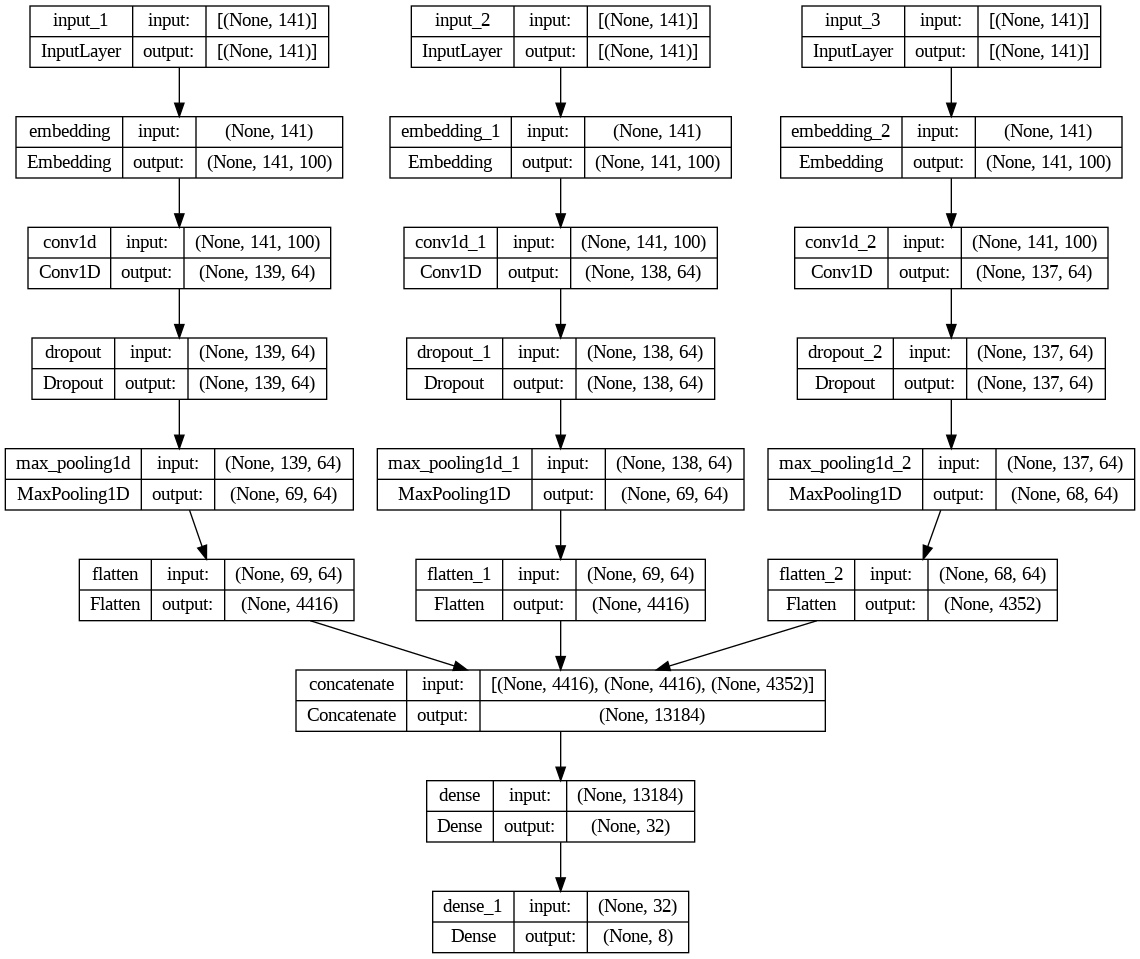

In [ ]:
plot_model(model, show_shapes = True, to_file = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/multichannel_cnn2a.png')


In [ ]:
print("Test Accuracy: ",acc)
print("Test Loss: ",loss)

Test Accuracy:  0.19417475163936615
Test Loss:  3.379373550415039


In [ ]:
y_predict = model.predict([X_test,X_test,X_test])
y_predict = np.round(y_predict)

10/10 [==============================] - 0s 2ms/step


In [ ]:
y_predict

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_predict = y_predict.astype('int32')
y_predict

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
#convert y_predict from one-hot encoding to label encoding
y_predict = np.argmax(y_predict, axis = 1)
y_predict

array([0, 1, 0, 0, 4, 0, 0, 5, 0, 2, 0, 0, 7, 1, 4, 0, 0, 0, 2, 3, 6, 6,
       0, 5, 1, 0, 1, 2, 0, 1, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 7, 0, 0, 1,
       0, 4, 0, 1, 1, 2, 1, 3, 0, 0, 0, 0, 3, 0, 0, 1, 4, 0, 5, 0, 7, 2,
       1, 5, 0, 0, 0, 0, 7, 6, 1, 0, 1, 6, 1, 1, 2, 0, 6, 3, 0, 5, 1, 2,
       2, 0, 0, 0, 3, 0, 0, 2, 0, 3, 0, 1, 2, 2, 0, 0, 0, 6, 0, 0, 0, 0,
       1, 3, 1, 6, 0, 0, 0, 2, 1, 0, 0, 0, 3, 0, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 0, 0, 3, 1, 0, 1, 1, 2, 1, 5, 6, 0, 0, 1, 2, 1, 0, 7, 3, 0,
       1, 0, 7, 0, 0, 0, 0, 3, 0, 0, 3, 0, 5, 1, 0, 1, 7, 0, 0, 0, 0, 7,
       0, 0, 1, 0, 7, 0, 3, 7, 0, 0, 3, 0, 0, 0, 3, 0, 3, 2, 0, 0, 3, 0,
       1, 4, 0, 0, 5, 1, 0, 0, 6, 2, 0, 2, 1, 0, 0, 0, 0, 3, 2, 7, 2, 3,
       6, 3, 1, 7, 0, 0, 1, 2, 1, 5, 0, 0, 2, 0, 0, 4, 0, 0, 1, 1, 0, 0,
       6, 0, 6, 0, 1, 1, 1, 2, 7, 1, 0, 0, 6, 7, 7, 6, 0, 1, 2, 3, 3, 7,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 7, 2, 0, 0, 0, 3, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 6, 2, 4, 0, 1, 1, 0,

In [ ]:
print('accuracy: %s' % acc)    
print(classification_report(Y_test, y_predict, target_names=labels))
print('f1 score: %s' % f1_score(Y_test, y_predict, average='macro'))

accuracy: 0.19417475163936615
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.12      0.40      0.18        43
causal_oversimplification       0.29      0.46      0.36        35
                    doubt       0.29      0.26      0.27        43
exaggeration,minimisation       0.16      0.13      0.15        30
              flag_waving       0.00      0.00      0.00        45
          loaded_language       0.11      0.03      0.04        39
    name_calling,labeling       0.13      0.06      0.08        34
               repetition       0.21      0.10      0.14        40

                 accuracy                           0.18       309
                macro avg       0.16      0.18      0.15       309
             weighted avg       0.16      0.18      0.15       309

f1 score: 0.15203627350552903


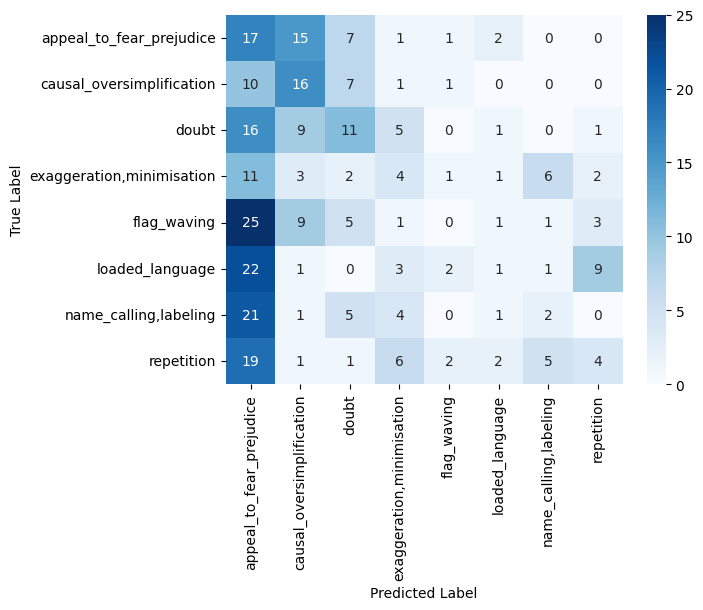

In [ ]:
# Plotting a confusion matrix
cm_cnn = confusion_matrix(Y_test, y_predict).astype(int)
sns.heatmap(cm_cnn, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Using LSTM (RNN)

#### Creating a LSTM Model
Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is particularly well-suited for handling sequential data, such as text data. It is designed to remember the context of the previous data points and use that information to process the current data point. This makes LSTM particularly useful for text classification tasks, such as spam detection, where the meaning of a word can depend on the context of the surrounding words.

I used BiLSTM model.

### Bi-LSTM

Global Vector or GloVe is an unsupervised learning algorithm for obtaining vector representations for words. I used glove.6B.100d to get word vectoe representation.

In [ ]:
# download glove.6B.zip
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-04-15 17:17:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-15 17:17:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-15 17:17:34--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
#unzip the file, we get multiple embedding files. We can use either one of them
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
embedding_dict = {}
# glove_file = open("glove.6B.100d.txt", encoding = "utf8")
glove_file = open("/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/glove.6B.100d.txt", encoding = "utf8")

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype = "float64")
  embedding_dict[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector 


In [ ]:
# let’s have a quick look how many of the embedding vectors are nonzero:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.37042025862068967

In [ ]:
embedding_vector_length = 100

In [ ]:
# A simple bidirectional LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(vocab_size, #Vocablury size
                    embedding_vector_length, #Embedding size
                    weights=[embedding_matrix], #Embeddings taken from pre-trained model
                    trainable=True, #So it will learn from our data
                    input_length=length,      #Number of words in each review
                    ) 
         )
model.add(Bidirectional(LSTM(300, activation = 'tanh', recurrent_activation = 'sigmoid', dropout=0.3, recurrent_dropout=0.3)))  #input_shape = (length,), return_sequences = True
model.add(Dense(units=32, activation = 'relu'))
model.add(Dense(8, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 141, 100)          371200    
                                                                 
 bidirectional (Bidirectiona  (None, 600)              962400    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                19232     
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 1,353,096
Trainable params: 1,353,096
Non-trainable params: 0
_________________________________________________________________


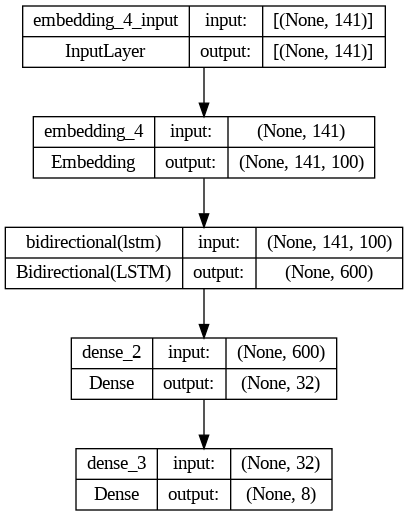

In [ ]:
# plot_model(model, show_shapes = True, to_file = '/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/bilstm_2.png')

In [ ]:
history=model.fit(X_train,Y_train,
          epochs=3,
          batch_size=32,          
          validation_data=(X_test, Y_test))

Epoch 1/3
41/41 [==============================] - 67s 1s/step - loss: 1.9061 - accuracy: 0.2200 - val_loss: 1.8155 - val_accuracy: 0.2362
Epoch 2/3
41/41 [==============================] - 57s 1s/step - loss: 1.7418 - accuracy: 0.2990 - val_loss: 1.7968 - val_accuracy: 0.2524
Epoch 3/3
41/41 [==============================] - 57s 1s/step - loss: 1.6586 - accuracy: 0.3579 - val_loss: 1.8428 - val_accuracy: 0.2168


In [ ]:
score = model.evaluate(X_test, Y_test, verbose = 1)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

10/10 [==============================] - 1s 81ms/step - loss: 1.8428 - accuracy: 0.2168
Test loss:  1.842780351638794
Test accuracy:  0.21682848036289215


In [ ]:
y_predict_bilstm = model.predict(X_test)

10/10 [==============================] - 2s 109ms/step


In [ ]:
y_predict_bilstm = np.argmax(y_predict_bilstm, axis = 1)
y_predict_bilstm

array([2, 2, 7, 6, 6, 3, 2, 5, 7, 2, 1, 3, 5, 2, 2, 6, 3, 6, 2, 6, 4, 6,
       7, 6, 2, 7, 2, 2, 2, 2, 6, 2, 1, 1, 2, 2, 2, 2, 6, 4, 5, 4, 2, 2,
       6, 3, 3, 2, 2, 3, 1, 4, 3, 3, 3, 4, 6, 2, 2, 2, 6, 3, 6, 2, 5, 2,
       2, 6, 2, 7, 3, 3, 7, 5, 2, 6, 2, 7, 3, 2, 3, 5, 3, 6, 3, 3, 2, 2,
       3, 5, 2, 2, 3, 7, 3, 3, 2, 6, 6, 2, 2, 3, 3, 3, 6, 4, 7, 3, 7, 3,
       2, 3, 2, 5, 6, 2, 3, 3, 2, 3, 2, 2, 6, 2, 6, 2, 3, 2, 1, 2, 3, 2,
       4, 2, 3, 3, 4, 2, 1, 3, 2, 2, 2, 6, 7, 5, 2, 2, 2, 2, 5, 5, 3, 6,
       2, 3, 5, 2, 7, 6, 7, 5, 6, 1, 6, 6, 6, 2, 7, 2, 6, 7, 6, 4, 6, 7,
       6, 2, 2, 6, 7, 6, 3, 6, 7, 5, 3, 4, 3, 3, 6, 2, 3, 3, 2, 5, 3, 3,
       2, 6, 6, 2, 3, 2, 1, 6, 6, 3, 5, 3, 2, 5, 7, 6, 3, 3, 2, 6, 3, 6,
       6, 6, 3, 7, 6, 6, 2, 3, 3, 6, 6, 3, 2, 7, 2, 3, 3, 6, 2, 2, 3, 6,
       6, 6, 6, 7, 2, 2, 2, 2, 5, 2, 3, 3, 6, 5, 5, 5, 2, 2, 2, 2, 3, 7,
       6, 2, 5, 3, 2, 2, 6, 6, 2, 7, 2, 2, 2, 5, 6, 2, 3, 5, 6, 5, 6, 2,
       3, 2, 7, 5, 3, 2, 3, 2, 3, 2, 6, 6, 2, 3, 4,

In [ ]:

print('accuracy: %s' % accuracy_score(y_predict_bilstm, Y_test))
print(classification_report(Y_test, y_predict_bilstm, target_names=labels))
print('f1 score: %s' % f1_score(Y_test, y_predict_bilstm, average='macro'))

accuracy: 0.2168284789644013
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.00      0.00      0.00        43
causal_oversimplification       0.25      0.06      0.09        35
                    doubt       0.25      0.58      0.35        43
exaggeration,minimisation       0.11      0.27      0.16        30
              flag_waving       0.09      0.02      0.04        45
          loaded_language       0.37      0.26      0.30        39
    name_calling,labeling       0.25      0.47      0.32        34
               repetition       0.19      0.12      0.15        40

                 accuracy                           0.22       309
                macro avg       0.19      0.22      0.18       309
             weighted avg       0.19      0.22      0.17       309

f1 score: 0.1765191728890497


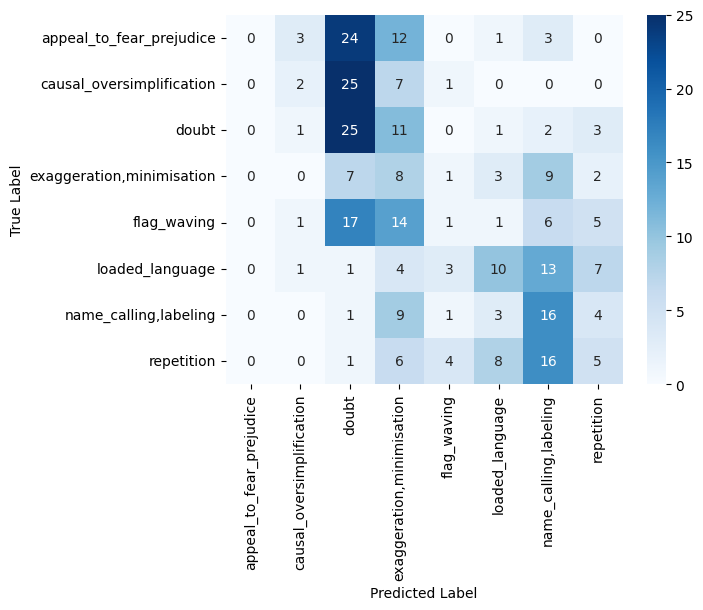

In [ ]:
# Plotting a confusion matrix
cm_lstm = confusion_matrix(Y_test, y_predict_bilstm).astype(int)
sns.heatmap(cm_lstm, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## BERT



### Transfer Learning 

Using only span text for bert training. I used pre trained `TFBertForSequenceClassification` model for fine tuning.

**Prepare the data**

In [ ]:
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.9 MB/s eta 0:00:00


In [ ]:
from transformers import *


In [ ]:
# for reproductivity of results
from transformers import set_seed
set_seed(random_seed)

In [ ]:
train_text = train_df1['span_text'].values
train_label = train_df1['labels'].values

test_text = test_df1['span_text'].values
test_label = test_df1['labels'].values

In [ ]:
### tokenize data using bert tokenizer
#Get BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_train_texts = [tokenizer.tokenize(sent) for sent in train_text]

#We will use only first 120 tokens to do classification
max_length = 120
tokenized_train_texts = [sent[:max_length] for sent in tokenized_train_texts]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_positio

In [ ]:
for i in range(len(tokenized_train_texts)):
    sent = tokenized_train_texts[i]
    sent = ['[CLS]'] + sent + ['[SEP]']
    tokenized_train_texts[i] = sent
    
#Convert tokens into IDs
input_train_ids = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_train_texts]

In [ ]:
tokenized_train_texts[0]

['[CLS]', 'american', 'people', '[SEP]']

In [ ]:
input_train_ids[0]

[101, 2137, 2111, 102]

In [ ]:
#Pad our tokens which might be less than max_length size
input_train_ids = pad_sequences(input_train_ids, maxlen=max_length, truncating='post', padding='post')

In [ ]:
tokenized_test_texts = [tokenizer.tokenize(sent) for sent in test_text]
tokenized_test_texts = [sent[:max_length] for sent in tokenized_test_texts]

for i in range(len(tokenized_test_texts)):
    sent = tokenized_test_texts[i]
    sent = ['[CLS]'] + sent + ['[SEP]']
    tokenized_test_texts[i] = sent
    
#Convert tokens into IDs
input_test_ids = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_test_texts]

#Pad our tokens which might be less than max_length size
input_test_ids = pad_sequences(input_test_ids, maxlen=max_length, truncating='post', padding='post')

Create Attention masks : Attention masks are useful to ignore padding tokens. Mask value will be set to 0 for padding tokens and 1 for actual tokens. We will create mask both for training and test data

In [ ]:
# Create attention masks for training
train_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_train_ids:
  seq_mask = [float(i>0) for i in seq]
  train_attn_masks.append(seq_mask)

In [ ]:
# Create attention masks for Test
test_attn_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_test_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attn_masks.append(seq_mask)

In [ ]:
model_bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 8)


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position

In [ ]:
optimizer = Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy('accuracy')
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model_bert.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_78 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6152      
                                                                 
Total params: 109,488,392
Trainable params: 109,488,392
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_x_data = {'input_ids': np.array(input_train_ids), 'attention_mask': np.array(train_attn_masks)}
test_x_data = {'input_ids': np.array(input_test_ids), 'attention_mask': np.array(test_attn_masks)}

In [ ]:
model_bert.fit(train_x_data, train_label, validation_data=(test_x_data, test_label), batch_size=32, epochs=5)

Epoch 1/5
41/41 [==============================] - 59s 926ms/step - loss: 1.9326 - accuracy: 0.2525 - val_loss: 1.7702 - val_accuracy: 0.3042
Epoch 2/5
41/41 [==============================] - 32s 776ms/step - loss: 1.5491 - accuracy: 0.4353 - val_loss: 1.5134 - val_accuracy: 0.4887
Epoch 3/5
41/41 [==============================] - 31s 767ms/step - loss: 1.1068 - accuracy: 0.6638 - val_loss: 1.2266 - val_accuracy: 0.5761
Epoch 4/5
41/41 [==============================] - 31s 768ms/step - loss: 0.7126 - accuracy: 0.7893 - val_loss: 1.1428 - val_accuracy: 0.6117
Epoch 5/5
41/41 [==============================] - 32s 770ms/step - loss: 0.3786 - accuracy: 0.9063 - val_loss: 1.1454 - val_accuracy: 0.6375


In [ ]:
## this object return scored before softmax
test_pred = model_bert.predict(test_x_data)[0]

## this will return probability score
tf_prediction = tf.nn.softmax(test_pred, axis=1).numpy()

## this will return predicted class labels
tf_prediction=np.argmax(tf_prediction,axis=1)
np.unique(tf_prediction)

10/10 [==============================] - 5s 237ms/step


array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
print('accuracy: %s' % accuracy_score(tf_prediction, test_label))
print(classification_report(test_label, tf_prediction, target_names=labels))
print('f1 score: %s' % f1_score(test_label, tf_prediction, average='macro'))

accuracy: 0.6375404530744336
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.58      0.72      0.65        43
causal_oversimplification       0.62      0.71      0.67        35
                    doubt       0.60      0.65      0.62        43
exaggeration,minimisation       0.68      0.57      0.62        30
              flag_waving       0.82      0.62      0.71        45
          loaded_language       0.61      0.59      0.60        39
    name_calling,labeling       0.72      0.68      0.70        34
               repetition       0.55      0.55      0.55        40

                 accuracy                           0.64       309
                macro avg       0.65      0.64      0.64       309
             weighted avg       0.65      0.64      0.64       309

f1 score: 0.6382671367837507


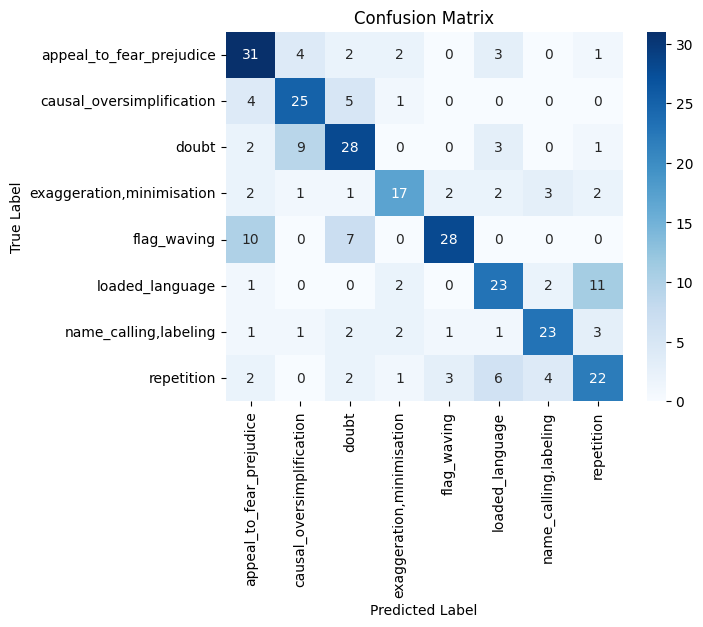

In [ ]:
# Plotting a confusion matrix
cm_tf = confusion_matrix(test_label, tf_prediction).astype(int)
sns.heatmap(cm_tf, annot=True, cmap='Blues',
xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/sussex_Ad_NLP/assignment/cm_best2.jpg', bbox_inches='tight', dpi = 300)
plt.show()

### Training BERT

In [ ]:
train_df2 = train_df[['tagged_in_context','labels']]
train_df2

,tagged_in_context,labels
2,"""The Obama administration misled the <BOS> Ame...",flag_waving
5,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",loaded_language
8,"As noted above, at this point literally every ...",doubt
10,His account was suspended for violating Twitte...,"name_calling,labeling"
12,A couple of seemingly unrelated events this pa...,appeal_to_fear_prejudice
...,...,...
2549,You might think that would have cured him of f...,repetition
2551,“I would like to take this opportunity to make...,"exaggeration,minimisation"
2552,Trump To Jeff Sessions: Put An End to Russia P...,flag_waving
2553,<BOS> Neither the Democrat leadership nor the ...,causal_oversimplification


In [ ]:
test_df2 = test_df[['tagged_in_context','labels']]
test_df2

,tagged_in_context,labels
1,Mostly because <BOS> the country would not las...,causal_oversimplification
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,appeal_to_fear_prejudice
4,It must be exacted from him directly in order ...,repetition
5,Is it any wonder that priests and laity alike ...,"name_calling,labeling"
6,Health workers have been asked to work with co...,loaded_language
...,...,...
629,"As a result, 58,177 <BOS> Americans <EOS> woul...",flag_waving
631,<BOS> But if you are a freedom-loving American...,flag_waving
632,I heard lots of <BOS> gut-wrenching stories <E...,loaded_language
638,<BOS> He also sang an Islamic State fight song...,flag_waving


In [ ]:
labellist=sorted(list(set(train_df2['labels'].unique()).union(set(test_df2['labels'].unique())))) 

labels_dict={label:i for i,label in enumerate(labellist)}
labels_dict

{'appeal_to_fear_prejudice': 0,
 'causal_oversimplification': 1,
 'doubt': 2,
 'exaggeration,minimisation': 3,
 'flag_waving': 4,
 'loaded_language': 5,
 'name_calling,labeling': 6,
 'repetition': 7}

In [ ]:
train_df2 = train_df2.replace({'labels':labels_dict})
train_df2

,tagged_in_context,labels
2,"""The Obama administration misled the <BOS> Ame...",4
5,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",5
8,"As noted above, at this point literally every ...",2
10,His account was suspended for violating Twitte...,6
12,A couple of seemingly unrelated events this pa...,0
...,...,...
2549,You might think that would have cured him of f...,7
2551,“I would like to take this opportunity to make...,3
2552,Trump To Jeff Sessions: Put An End to Russia P...,4
2553,<BOS> Neither the Democrat leadership nor the ...,1


In [ ]:
test_df2 = test_df2.replace({'labels':labels_dict})
test_df2

,tagged_in_context,labels
1,Mostly because <BOS> the country would not las...,1
2,Lyndon Johnson <BOS> gets Earl Warren and Sen....,0
4,It must be exacted from him directly in order ...,7
5,Is it any wonder that priests and laity alike ...,6
6,Health workers have been asked to work with co...,5
...,...,...
629,"As a result, 58,177 <BOS> Americans <EOS> woul...",4
631,<BOS> But if you are a freedom-loving American...,4
632,I heard lots of <BOS> gut-wrenching stories <E...,5
638,<BOS> He also sang an Islamic State fight song...,4


In [ ]:
def preprocess_text(text):
    text = text.lower() # lowercase text
    text = re.sub('[^0-9A-Za-z]+', ' ', text)
    text = ' '.join(word for word in text.split()) 
    return text

In [ ]:
train_df2['tagged_in_context'] = train_df2['tagged_in_context'].apply(preprocess_text)
test_df2['tagged_in_context'] = test_df2['tagged_in_context'].apply(preprocess_text)

In [ ]:
training_text = train_df2['tagged_in_context'].values
train_tokenized_sents = [sent.split() for sent in training_text]
print(train_tokenized_sents[:5])

[['the', 'obama', 'administration', 'misled', 'the', 'bos', 'american', 'people', 'eos', 'and', 'congress', 'because', 'they', 'were', 'desperate', 'to', 'get', 'a', 'deal', 'with', 'iran', 'said', 'sen'], ['hitler', 'bos', 'annihilated', 'eos', '400', '000', 'germans', 'who', 'were', 'handicapped', 'or', 'suffered', 'from', 'chronic', 'diseases'], ['as', 'noted', 'above', 'at', 'this', 'point', 'literally', 'every', 'piece', 'of', 'bos', 'so', 'called', 'evidence', 'eos', 'put', 'forth', 'by', 'authorities', 'and', 'then', 'regurgitated', 'by', 'the', 'mainstream', 'media', 'cannot', 'be', 'trusted', 'and', 'should', 'be', 'considered', 'as', 'disinformation', 'until', 'proven', 'otherwise'], ['his', 'account', 'was', 'suspended', 'for', 'violating', 'twitter', 's', 'rules', 'relating', 'to', 'bos', 'hateful', 'conduct', 'eos', 'it', 'is', 'hateful', 'conduct', 'apparently', 'to', 'reference', 'what', 'islamic', 'texts', 'themselves', 'say'], ['a', 'couple', 'of', 'seemingly', 'unrela

In [ ]:
testing_text = test_df2['tagged_in_context'].values
test_tokenized_sents = [sent.split() for sent in testing_text]
print(test_tokenized_sents[:5])

[['mostly', 'because', 'bos', 'the', 'country', 'would', 'not', 'last', 'long', 'without', 'an', 'outside', 'high', 'iq', 'elite', 'to', 'run', 'the', 'country', 'eos'], ['lyndon', 'johnson', 'bos', 'gets', 'earl', 'warren', 'and', 'sen', 'richard', 'russel', 'to', 'join', 'the', 'warren', 'commission', 'by', 'telling', 'them', 'that', 'the', 'assassination', 'could', 'lead', 'to', 'world', 'war', 'iii', 'eos'], ['it', 'must', 'be', 'exacted', 'from', 'him', 'directly', 'in', 'order', 'to', 'vilify', 'and', 'humiliate', 'him', 'so', 'that', 'islam', 'and', 'its', 'people', 'may', 'be', 'exalted', 'and', 'the', 'race', 'of', 'bos', 'infidels', 'eos', 'brought', 'low'], ['is', 'it', 'any', 'wonder', 'that', 'priests', 'and', 'laity', 'alike', 'are', 'changing', 'their', 'attitude', 'on', 'bos', 'the', 'gay', 'lifestyle', 'eos', 'and', 'violations', 'of', 'the', 'sixth', 'commandment', 'when', 'so', 'many', 'bishops', 'are', 'working', 'to', 'remove', 'the', 'stigma', 'attached', 'to', 't

In [ ]:
def make_segment_ids(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    start = list_of_tokens.index('bos')
    end = list_of_tokens.index('eos')

    substring = list_of_tokens[start:end-1]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token in substring:
            current_id=1
        else:
          current_id = 0
    return segment_ids

In [ ]:
token_seg_ids = [make_segment_ids(sent) for sent in train_tokenized_sents]
token_seg_ids[:2]

[[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [ ]:
print("Tokenized sentences: \n", train_tokenized_sents[0])
print("\n", train_tokenized_sents[6])
print("------------------")
print("Segment Ids: \n", token_seg_ids[0])
print("\n", token_seg_ids[6])

Tokenized sentences: 
 ['the', 'obama', 'administration', 'misled', 'the', 'bos', 'american', 'people', 'eos', 'and', 'congress', 'because', 'they', 'were', 'desperate', 'to', 'get', 'a', 'deal', 'with', 'iran', 'said', 'sen']

 ['bos', 'but', 'who', 'authorized', 'this', 'strategic', 'commitment', 'eos', 'of', 'indefinite', 'duration', 'in', 'syria', 'when', 'near', 'two', 'decades', 'in', 'afghanistan', 'have', 'failed', 'to', 'secure', 'that', 'nation', 'against', 'the', 'return', 'of', 'al', 'qaida', 'and', 'isis']
------------------
Segment Ids: 
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# code from advanced nlp labwork
from tqdm.auto import tqdm
def encode(tokenized_sents, method="sum",poolinglayer=-1):
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model.eval()
    encoded=[]
    blacklist=['bos','eos']
    for sent in tqdm(tokenized_sents):
          indexed_tokens = tokenizer.convert_tokens_to_ids(sent)
          segment_ids=make_segment_ids(sent)
          tokens_tensor = torch.tensor([indexed_tokens])
          segments_tensors = torch.tensor([segment_ids])

          # Predict all tokens
          with torch.no_grad():
              outputs = model(tokens_tensor, token_type_ids=segments_tensors,output_hidden_states=True)
              if poolinglayer==0:
                  predictions = outputs[0]
              else:
                  predictions = outputs[2][poolinglayer]
                  
          if method=="sum":
              rep=sum(predictions[0])
          elif method=="cls":
              rep=predictions[0][0]
          elif method=="centroid":
              rep=sum(predictions[0])
              rep=rep/len(predictions[0])
          elif method=="centroid-":
              rep=predictions[0][1]
              for tok,pred in zip(sent[2:],predictions[0][2:]):
                  if tok not in blacklist:
                      rep+=pred
              rep=rep/len(predictions[0][1:])
                      
          
          else:
              rep=predictions[0][0]
          encoded.append(rep)
        
    return encoded

In [ ]:
train_encoding=encode(train_tokenized_sents,method="cls",poolinglayer=-1)
print(train_encoding[0])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

  0%|          | 0/1291 [00:00<?, ?it/s]

tensor([ 3.0736e-01,  1.5177e-01,  8.1061e-02,  4.5953e-01, -5.2264e-02,
        -2.5394e-01, -3.5014e-01, -6.8995e-03, -5.9556e-02, -2.4296e-01,
        -7.2819e-02, -1.1792e-02, -2.0937e-01,  2.6739e-01,  9.4949e-02,
         3.1813e-01, -2.6136e-01,  8.4719e-02,  1.4645e-01, -3.0827e-01,
         1.0108e-01,  9.3827e-02,  3.7318e-01, -2.3981e-01, -1.3630e-01,
        -8.8741e-02,  3.6564e-01, -2.1868e-01, -2.6806e-01,  2.3949e-01,
         1.6470e-01, -7.2528e-01, -2.5421e-01, -1.3054e-02, -3.6411e-01,
        -4.1758e-01,  4.2067e-01, -1.3792e-01, -3.6960e-02, -1.6723e-01,
        -1.9329e-01, -3.1516e-01,  5.8012e-02, -3.6802e-01, -6.4501e-01,
        -8.2498e-02, -9.8266e-01,  3.1723e-01,  1.4160e-01, -2.2336e-01,
        -4.1217e-01,  1.7223e-01,  2.5638e-01,  5.2426e-02, -9.2970e-02,
         1.4675e-01, -1.5481e-01, -5.3225e-01, -2.8659e-01, -4.1669e-01,
         9.4322e-01, -1.8776e-01, -6.3445e-02, -3.8743e-01,  4.4309e-02,
         2.9106e-01,  1.4547e-01, -2.6938e-01, -1.9

In [ ]:
test_encoding=encode(test_tokenized_sents,method="cls",poolinglayer=-1)
print(test_encoding[0])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.27.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/pytorch_model.bin
Some weights of the model check

  0%|          | 0/309 [00:00<?, ?it/s]

tensor([ 5.1824e-01,  1.3360e-01,  3.4804e-01,  4.9417e-02, -2.8839e-01,
         9.3844e-02,  1.0361e-01,  2.6716e-01,  1.0456e-01, -3.2059e-01,
        -8.5922e-02,  1.1797e-01, -9.0222e-02,  5.2147e-02,  4.3602e-01,
         2.7436e-01,  3.7117e-01,  2.4129e-01,  3.0178e-01, -3.7053e-01,
         6.5020e-01,  2.3714e-01,  4.6809e-01,  2.6401e-01,  1.2332e-01,
        -1.1760e-01,  2.9666e-01,  6.0219e-02, -1.6028e-01,  1.5599e-01,
         4.3551e-01, -1.0499e-01, -2.1414e-01, -9.3470e-02,  1.2553e-01,
        -5.6666e-01,  2.5283e-01,  4.1270e-01, -2.2103e-01,  7.9308e-02,
        -2.5395e-01,  1.1600e-01,  2.1097e-01, -1.6787e-01, -2.9813e-01,
        -3.2506e-01, -1.8480e+00, -2.0377e-02, -8.2659e-02, -4.7555e-01,
        -3.5004e-01, -2.9129e-01, -3.1086e-01,  6.9909e-02, -2.3716e-01,
         6.6681e-01, -6.5384e-01, -5.7535e-01, -8.3336e-01, -5.9297e-01,
         6.9839e-01, -3.7485e-01, -3.3172e-01, -1.6456e-01, -2.3010e-01,
         2.6055e-01,  1.0668e-01,  4.9291e-01, -2.4

In [ ]:
training_encoding_np = [encoding.numpy() for encoding in train_encoding]
testing_encoding_np = [encoding.numpy() for encoding in test_encoding]

In [ ]:
training_labels = train_df2['labels'].values
training_labels = np.array(training_labels, dtype = int)

In [ ]:
testing_labels = test_df2['labels'].values

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, random_state=random_seed)
clf.fit(training_encoding_np,training_labels)
predicted_mlp = clf.predict(testing_encoding_np)

In [ ]:
# Model evaluation
print('accuracy: %s' % accuracy_score(predicted_mlp, testing_labels))
print(classification_report(testing_labels, predicted_mlp, target_names=labels_dict.keys()))
print('f1 score: %s' % f1_score(testing_labels, predicted_mlp, average='macro'))

accuracy: 0.4368932038834951
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.37      0.33      0.35        43
causal_oversimplification       0.49      0.60      0.54        35
                    doubt       0.49      0.47      0.48        43
exaggeration,minimisation       0.27      0.33      0.30        30
              flag_waving       0.61      0.44      0.51        45
          loaded_language       0.38      0.31      0.34        39
    name_calling,labeling       0.46      0.50      0.48        34
               repetition       0.44      0.53      0.48        40

                 accuracy                           0.44       309
                macro avg       0.44      0.44      0.43       309
             weighted avg       0.44      0.44      0.44       309

f1 score: 0.4332291422785256


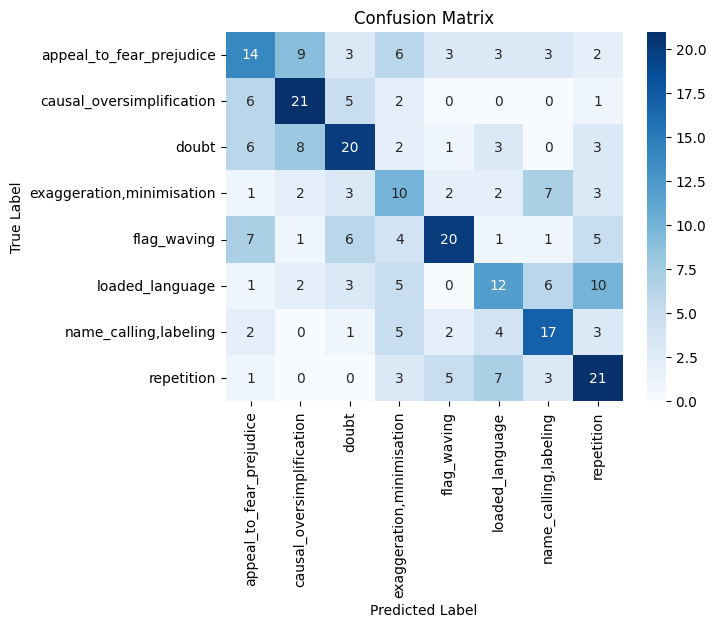

In [ ]:
# Plotting a confusion matrix
cm = confusion_matrix(testing_labels, predicted_mlp).astype(int)
sns.heatmap(cm, annot=True, cmap='Blues',
xticklabels=labels_dict.keys(), yticklabels=labels_dict.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Reference**

1. https://stackoverflow.com/questions/4666973/how-to-extract-the-substring-between-two-markers
2. https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
3. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
